In [201]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow
import keras
import keras.backend as K

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from general.visdl import *
from general.datasets import *
import quiver_engine.server
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load model

In [6]:
model = keras.models.load_model('model.h5')

In [175]:
import pickle
import bz2

with bz2.BZ2File("data/dataset.pickle.bz2", "r") as f:
    data = pickle.load(f)

In [176]:
data.show()

train
  - X: (1323, 100, 100, 3)
  - y: (1323, 2)
train_dev
  - X: (148, 100, 100, 3)
  - y: (148, 2)
dev
  - X: (491, 100, 100, 3)
  - y: (491, 2)
test
  - X: (490, 100, 100, 3)
  - y: (490, 2)
small
train
  - X: (500, 100, 100, 3)
  - y: (500, 2)
test
  - X: (500, 100, 100, 3)
  - y: (500, 2)


## Visualizing model

In [37]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_99 (Convolution2D) (None, 16, 98, 98)    448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_100 (Convolution2D)(None, 16, 96, 96)    2320        convolution2d_99[0][0]           
____________________________________________________________________________________________________
maxpooling2d_50 (MaxPooling2D)   (None, 16, 48, 48)    0           convolution2d_100[0][0]          
____________________________________________________________________________________________________
dropout_13 (Dropout)             (None, 16, 48, 48)    0           maxpooling2d_50[0][0]            
___________________________________________________________________________________________

In [238]:
mv = ModelVis(model)
mv = mv.maximize_activation(5,0)

input_shape starts with -  [1 1]
layer -  <keras.layers.convolutional.Convolution2D object at 0x11d863eb8>
input_shape =  [3 3]
layer -  <keras.layers.convolutional.Convolution2D object at 0x11d84c390>
input_shape =  [5 5]
layer -  <keras.layers.core.Dropout object at 0x11d80bfd0>
input_shape =  [5 5]
layer -  <keras.layers.pooling.MaxPooling2D object at 0x11d74fcc0>
input_shape =  [10 10]
layer -  <keras.layers.convolutional.Convolution2D object at 0x11d734ac8>
input_shape =  [12 12]
layer -  <keras.layers.convolutional.Convolution2D object at 0x11d734630>
input_shape =  [14 14]


In [465]:
model.layers[0].input

<tf.Tensor 'convolution2d_input_1:0' shape=(?, 3, 100, 100) dtype=float32>

In [463]:
layer_num = 0
filter_num = 6

input_placeholder = model.layers[0].input
activation = model.layers[layer_num].output[:, filter_num, 0, 0]
#activation_loss = 1/(activation + 1e-6)

# opt = K.tf.train.AdagradOptimizer(0.01)
# train_op = opt.minimize(activation_loss, var_list=[input_placeholder])

grads = K.gradients(activation, input_placeholder)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([input_placeholder, K.learning_phase()], [activation, grads], allow_input_downcast=True)

#input = np.random.random((1,3,100,100))
input = mean_img.transpose((2,0,1))[None, :]
#input = np.zeros((1,3,100,100))
#input[:,:,:14,:14] = np.random.random((1,3,14,14))


for i in range(100):
    act, grads = iterate([input, False])
#    input += (0.98**i)*0.1*grads
    print(np.linalg.norm(grads))
    input += 1*grads
print("activation - ", act)    

/Users/zach/anaconda3/lib/python3.5/site-packages/Keras-1.1.0-py3.5.egg/keras/backend/tensorflow_backend.py:1057: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
activation -  [ 0.]


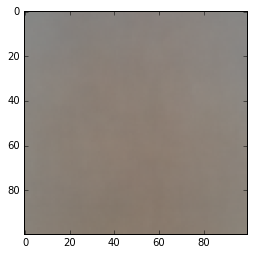

In [460]:
plt.imshow(input[0].transpose(1,2,0)[:,:,:], interpolation='nearest')

In [477]:
mean_img = data.train.X.mean(axis=(0))
mean_channel_img = data.train.X.mean(axis=(0,1,2))

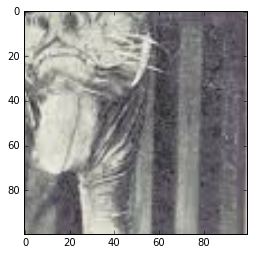

In [489]:
plt.imshow((data.train.X[7] - mean_img)/data.train.X.std(axis=(0)))
plt.imshow(data.train.X[7])

In [474]:
data.train.X.shape

(1323, 100, 100, 3)

In [478]:
mean_channel_img.shape

(3,)

In [479]:
(data.train.X[0] - mean_channel_img).shape

(100, 100, 3)

ValueError: axes don't match array

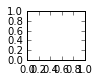

In [314]:
for i in range(a.shape[1]):
    plt.subplot(4,a.shape[1]/4+1,i+1)
    plt.imshow(a[0][i][:14,:14], cmap='gray',vmin=0, vmax=1)
    plt.title("layer {}".format(i))
    plt.axis('off')
              
plt.show()


## Visualize filter activation

In [191]:
def activate_filter(model, layer_id, filter_num):
    if isinstance(layer_id, int):
        layer = model.layers[layer_id]
    else:
        layer = model.get_layer(layer_id)
    

    input_img = model.layers[0].input
    layer_output = layer.output
    
    loss = K.mean(layer_output[:,filter_num,:,:])
    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([input_img, K.learning_phase()], [loss, grads, layer_output])

    # start with a random input
    input_shape = (1,) + tuple(x.value for x in input_img.get_shape()[1:])
    input_data = np.random.random(input_shape) * 20 + 118
    
    step = 0.1
    activations = None
    for i in range(200):
        loss_val, grads_val, activations = iterate([input_data, False])
        if np.all(grads_val==0):
            print("all grads are 0")
            return input_data, activations
            
        if i%10==0:
            print("loss={}".format(loss_val))
        input_data -= grads_val * step
        
    return input_data, activations
    
                      
        
    

In [192]:
img, activations = activate_filter(model, 'convolution2d_102', 14)

loss=62.23530197143555
loss=53.87474060058594
loss=46.137413024902344
loss=38.63540267944336
loss=31.27195930480957
loss=24.000368118286133
loss=16.789735794067383
loss=9.627616882324219
loss=3.57747220993042
loss=1.2334600687026978
loss=0.262628972530365
loss=0.01508589182049036
loss=5.192629396333359e-05
all grads are 0


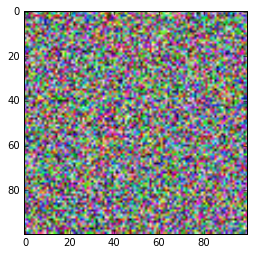

In [200]:
plt.imshow( img[0].transpose(1,2,0), vmin=0, vmax=255)

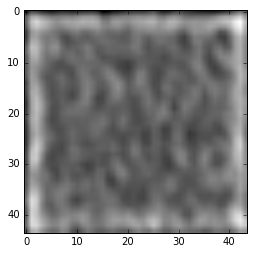

In [202]:
plt.imshow( activations[0][1], cmap='gray')

In [196]:
activations

array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         ..., 
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]],

        [[ 16.63365173,  29.37857819,  26.84044266, ...,  32.29605865,
           38.21356583,  32.79219818],
         [ 34.82297897,  52.6205101 ,  54.19985962, ...,  57.37557983,
           63.59078598,  49.2888298 ],
         [ 37.33347321,  60.07583237,  65.72129059, ...,  71.2990799 ,
           75.84509277,  58.1653

In [156]:
model.get_layer('convolution2d_102').get_weights().shape

(16, 16, 3, 3)

In [179]:
layer = model.get_layer('convolution2d_102')
input_img = model.layers[0].input
layer_output = layer.output

loss = K.mean(layer_output[:,14,:,:])
grads = K.gradients(loss, input_img)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([input_img, K.learning_phase()], [loss, grads, layer_output])
act = iterate([input_data, False])[2]

In [180]:
act.shape

(1, 16, 44, 44)

In [181]:
act[0][14]

array([[ 59.3808403 ,  58.63658142,  58.59918594, ...,  62.545784  ,
         63.09395599,  64.74386597],
       [ 58.68403625,  59.28665924,  60.57155991, ...,  66.54695892,
         66.54452515,  65.04660797],
       [ 58.30429459,  60.94254303,  62.94651413, ...,  65.72563171,
         66.60758209,  65.286026  ],
       ..., 
       [ 67.58496857,  67.44807434,  66.04122162, ...,  54.83904648,
         57.26311874,  59.02160645],
       [ 65.73597717,  67.60940552,  65.93484497, ...,  53.97267532,
         53.99604797,  56.27903748],
       [ 62.96004105,  63.76463318,  63.81710052, ...,  54.41477585,
         55.35417938,  58.95701218]], dtype=float32)